In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import helper
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import  silhouette_score

In [2]:
profiles = pd.read_json('../../starbuck_capstone/data/profile.json',orient='records',lines=True)
transcripts = pd.read_json('../../starbuck_capstone/data/transcript.json',orient='records',lines=True)
promotions = pd.read_json('../../starbuck_capstone/data/portfolio.json',orient='records',lines=True)

In [3]:
 trans_dt, trans_clean_dt = helper.transaction_preprocessing(profiles,transcripts,promotions)

File load from local directory as it was already available


In [4]:
print('shape of trans_dt:',trans_dt.shape)
print('shape of trans_clean_dt:',trans_clean_dt.shape)

shape of trans_dt: (306534, 19)
shape of trans_clean_dt: (297057, 19)


In [5]:
final_df = helper.feature_engineering(trans_dt,trans_clean_dt, profiles, promotions)

## 1. EDA:

### 1.1 Missing Values: 

Text(0.5, 1.0, 'Missing Counts Per Column')

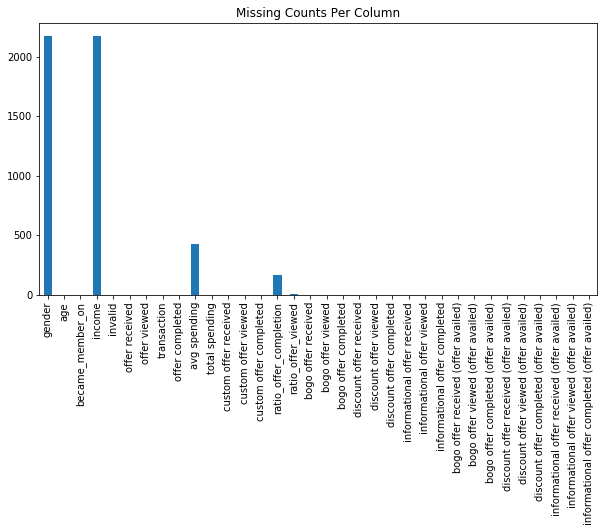

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
final_df.isnull().sum().plot(kind='bar')
ax.set_title('Missing Counts Per Column')

## 2. Preprocessing

### 2.1 Missing Values:

In [7]:
(final_df.isnull().sum()/len(final_df))*100

gender                                           12.794118
age                                               0.000000
became_member_on                                  0.000000
income                                           12.794118
invalid                                           0.000000
offer received                                    0.000000
offer viewed                                      0.000000
transaction                                       0.000000
offer completed                                   0.000000
avg spending                                      2.482353
total spending                                    0.000000
custom offer received                             0.000000
custom offer viewed                               0.000000
custom offer completed                            0.000000
ratio_offer_completion                            0.976471
ratio_offer_viewed                                0.035294
bogo offer received                               0.0000

In [8]:
## Fill out data with mean and mode (naive approach)
def fill_data(df,columns):
    """
    fill data based on mean (continuous) and mode (categorical)
    """
    for col in columns:
        if col == 'gender':
            mode = df.gender.mode()[0]
            df['gender'] = df['gender'].fillna(mode)
        else:
            if col in ['ratio_offer_completion','ratio_offer_viewed']:
                median = final_df[col].median()
                df[col] = df[col].fillna(median)
            else:
                mean = df[col].mean()
                df[col] = df[col].fillna(mean)
    return df

In [9]:
mis_cols = final_df.columns[final_df.isnull().sum() >0 ].tolist()
mis_cols

['gender',
 'income',
 'avg spending',
 'ratio_offer_completion',
 'ratio_offer_viewed']

In [10]:
final_df = fill_data(final_df,mis_cols)

In [162]:
final_df.isnull().sum()

gender                                           0
age                                              0
became_member_on                                 0
income                                           0
invalid                                          0
offer received                                   0
offer viewed                                     0
transaction                                      0
offer completed                                  0
avg spending                                     0
total spending                                   0
custom offer received                            0
custom offer viewed                              0
custom offer completed                           0
ratio_offer_completion                           0
ratio_offer_viewed                               0
bogo offer received                              0
bogo offer viewed                                0
bogo offer completed                             0
discount offer received        

### 2.2 Associations and Correlations 

- How different males from female on based on offer completion and offer viewed rate? 

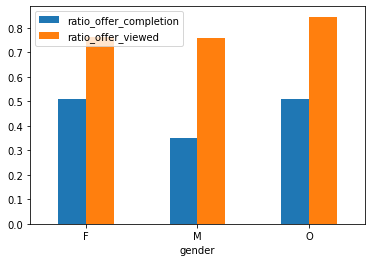

In [19]:
agg = final_df.groupby(by=['gender'])['ratio_offer_completion','ratio_offer_viewed'].mean().plot(kind='bar',rot=0)

<b style="color:red;" > Observation: </b>
__females__ and __Others__ have on average high tendency to view and complete the offer. (gender can be create distinction). 

- How different female are from male based on spending, age and income? 

Text(0.5, 1.0, 'income by gender')

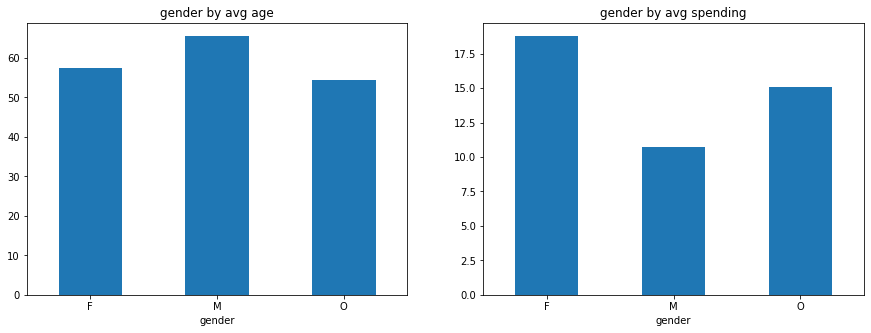

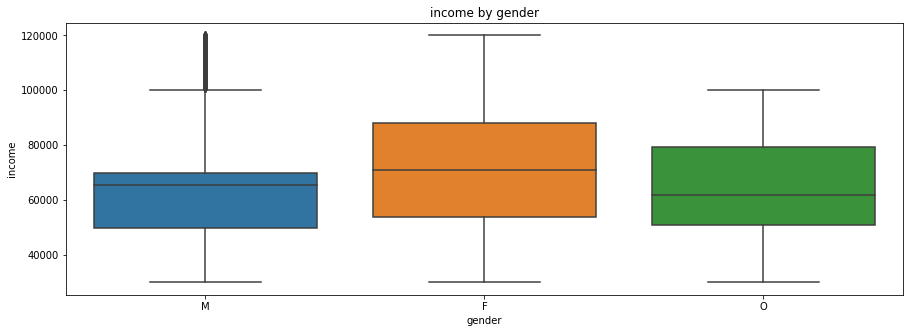

In [39]:
fig, ax = plt.subplots(ncols=2,figsize=(15,5))
final_df.groupby(by=['gender'])['age'].mean().plot(kind='bar',rot=0, ax=ax[0],title="gender by avg age")
final_df.groupby(by=['gender'])['avg spending'].mean().plot(kind='bar',rot=0, ax=ax[1],title="gender by avg spending")
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y = final_df['income'], x=final_df['gender'])
ax.set_title('income by gender')

<b style="color:red;"> Observation: </b>
- Female on average earn more than male and others probably that's why they have high avg spending compared with rest of the gender in addition they are as old as males. 
- Others on average have low income than male and female but their avg spending is second highest next to female. 
- It seems like income, gender, avg spending and age can create distinction between clusters. 

- Just because male are older than females is this the only reason why they spending less on average? let's see. 

In [42]:
final_df = final_df.assign(age_bucket=pd.cut(final_df['age'],5))

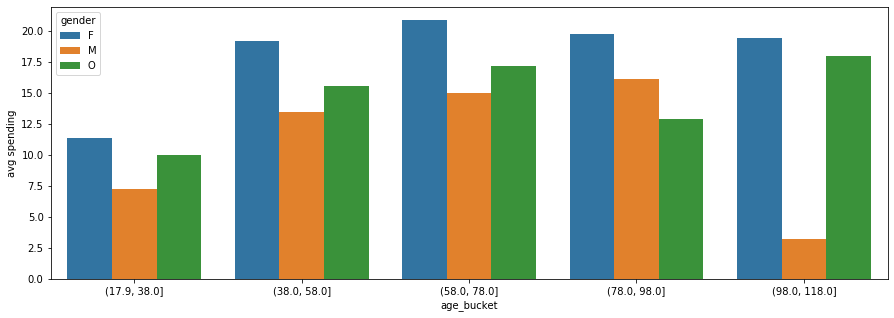

In [46]:
fig, ax = plt.subplots(figsize=(15,5))
agg = final_df.groupby(by=['age_bucket','gender'])['avg spending'].mean().reset_index()
sns.barplot(x='age_bucket',y='avg spending',hue='gender',data=agg, ci=False)

<b style="color:red;"> Observation: </b>
- It is not the case as male in all age bucket except 78-98 have fairly low avg spending compared to rest of the genders. The low avg spending in males is not due to they are older. 

- Are males regular customers and females seasonal? 

Text(0.5, 1.0, 'gender w.r.t number of regular transaction (without offer)')

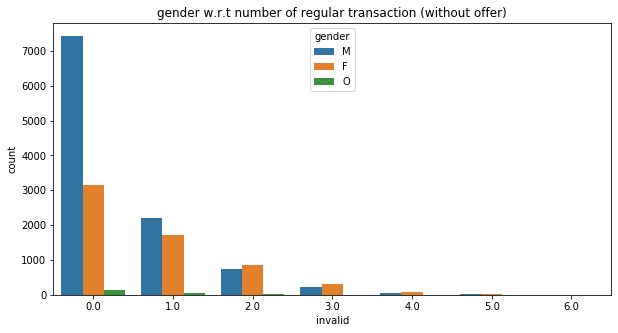

In [50]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(final_df['invalid'],hue=final_df['gender'])
ax.set_title('gender w.r.t number of regular transaction (without offer)')

<b style="color:red;"> Observation: </b>
- Females have more regular transactions than males although females have high offer completion ratio than male (in first visualization of this notebook). It seems like there is some division within females such that one segments goes for offer and one segment goes for regular transaction. 

- What are the distinct characteristics of females who opt for regular transaction than those who go to offers? 

In [70]:
females = final_df[(final_df['gender'] == 'F')]

In [197]:
females = females.assign(invalid_l2 = females['invalid'].apply(lambda x: 1 if x > 0 else 0))

In [198]:
female_reg = females[females['invalid_l2']==0]
female_sea = females[females['invalid_l2']==1]

In [203]:
print('regular customers (female) :', len(female_reg),'\nseasonal customers (female) :', len(female_sea) )

regular customers (female) : 3164 
seasonal customers (female) : 2965


1. Age

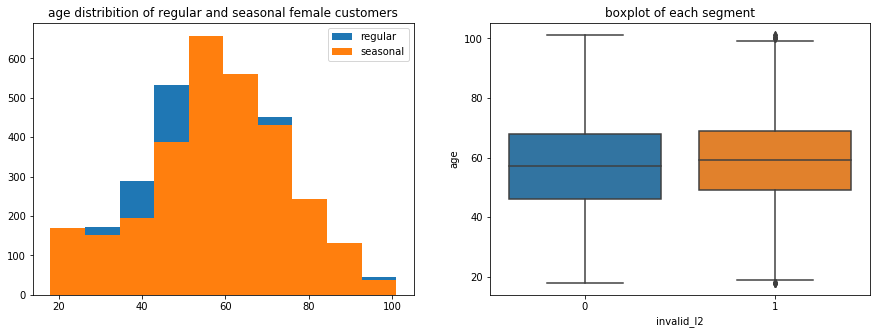

In [199]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].hist(female_reg['age'])
ax[0].hist(female_sea['age'])
ax[0].set_title('age distribition of regular and seasonal female customers')
ax[0].legend(['regular','seasonal'])
sns.boxplot(y=females['age'],x=females['invalid_l2'],ax=ax[1])
ax[1].set_title('boxplot of each segment')
plt.show()

In [200]:
females.groupby(by=['invalid_l2'])['age'].describe()

,count,mean,std,min,25%,50%,75%,max
invalid_l2,,,,,,,,
0,3164.0,56.985145,16.837381,18.0,46.0,57.0,68.0,101.0
1,2965.0,58.142327,16.914606,18.0,49.0,59.0,69.0,101.0


2. income and avg spending. 

In [204]:
females.groupby(by=['invalid_l2'])['income','avg spending'].agg(['mean','median','min','max','sum'])

income                                           \
                    mean   median      min       max          sum   
invalid_l2                                                          
0           68442.161820  67000.0  30000.0  120000.0  216551000.0   
1           74362.900506  74000.0  30000.0  120000.0  220486000.0   

           avg spending                                            
                   mean   median       min      max           sum  
invalid_l2                                                         
0             16.698112  15.6625  0.240000  451.470  52832.824830  
1             21.027813  19.8350  1.806154  291.315  62347.464308

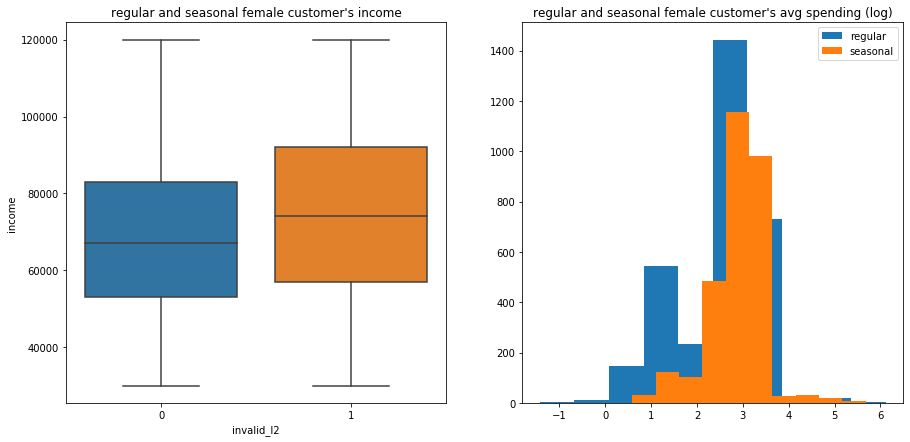

In [263]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
sns.boxplot(x='invalid_l2',y='income',data=females,ax=ax[0])
ax[0].set_title('regular and seasonal female customer\'s income')
plt.hist(np.log(female_reg['avg spending']))
plt.hist(np.log(female_sea['avg spending']))
ax[1].set_title('regular and seasonal female customer\'s avg spending (log)')
ax[1].legend(['regular','seasonal'])
plt.show()

3. offer completion and offer view rate. 

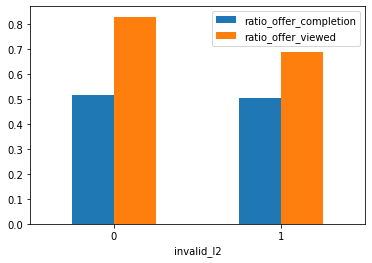

In [129]:
females.groupby(by=['invalid_l2'])['ratio_offer_completion','ratio_offer_viewed'].mean().plot(kind='bar',rot=0)

In [130]:
females.groupby(by=['invalid_l2'])['ratio_offer_completion','ratio_offer_viewed'].mean()

,ratio_offer_completion,ratio_offer_viewed
invalid_l2,,
0,0.514654,0.829867
1,0.505267,0.688252


4. member of starbucks since. 

In [134]:
def convert_into_dateformat(df, col):
    """
    Function to convert date into pandas datatime format. 
    
    Input: dataframe and column (contain date)
    Output: dataframe containing date (date time format)
    """
    # make a copy of dataframe #
    df = df.copy()
    # convert it into string #
    df[col] = df[col].astype(str)
    df[col] = pd.to_datetime(df[col])
    
    return df

In [136]:
females = convert_into_dateformat(females,'became_member_on')

In [165]:
# fetch year and month from member join date #
females = females.assign(member_year=pd.DatetimeIndex(females['became_member_on']).year)
females = females.assign(member_month=pd.DatetimeIndex(females['became_member_on']).month)
females = females.assign(member_days=pd.DatetimeIndex(females['became_member_on']).day)

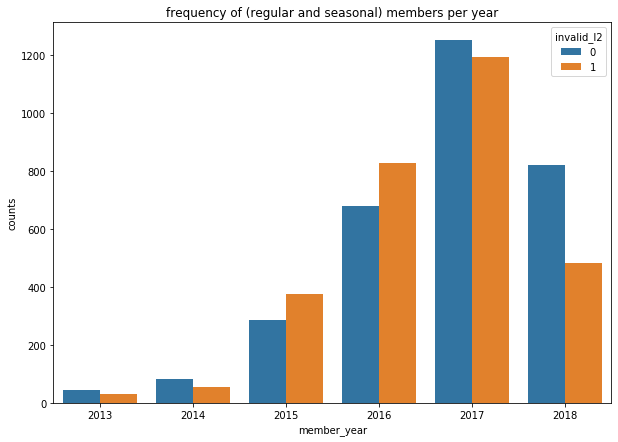

In [163]:
fig, ax = plt.subplots(figsize=(10,7))
agg = females.groupby(by=['member_year','invalid_l2']).size().reset_index().rename(columns={0:'counts'})
sns.barplot(x='member_year',y='counts', hue='invalid_l2', data=agg, ci=False)
ax.set_title('frequency of (regular and seasonal) members per year')
plt.show()

5. custom offer complete and view:

In [175]:
females.groupby(by=['invalid_l2'])['custom offer completed','custom offer viewed'].median()

,custom offer completed,custom offer viewed
invalid_l2,,
0,2,4
1,2,3


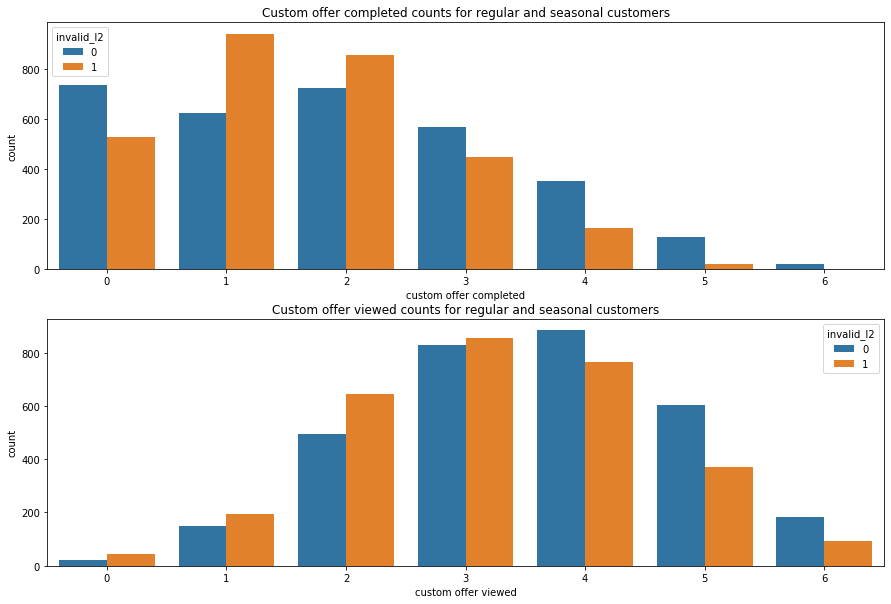

In [207]:
fig, ax = plt.subplots(nrows=2,figsize=(15,10))
sns.countplot(females['custom offer completed'],hue=females['invalid_l2'], ax =ax[0])
ax[0].set_title('Custom offer completed counts for regular and seasonal customers')

sns.countplot(females['custom offer viewed'],hue=females['invalid_l2'],ax=ax[1])
ax[1].set_title('Custom offer viewed counts for regular and seasonal customers')
plt.show()



6. no of transactions. 

In [220]:
def add_no_transactions(customers, trans_dt):
    """
    count total number of transaction by each customer 
    """
    customers = customers.copy()
    transactions_only = trans_dt[trans_dt['event']=='transaction']
    frequency = transactions_only.groupby(by=['person']).size()
    customers = customers.assign(total_transactions = frequency)
    return customers

In [227]:
females = add_no_transactions(females, trans_dt)

In [229]:
females.groupby(by=['invalid_l2'])['total_transactions'].describe()

,count,mean,std,min,25%,50%,75%,max
invalid_l2,,,,,,,,
0,3028.0,7.653236,4.622445,1.0,4.0,7.0,10.0,28.0
1,2965.0,8.839123,4.720968,1.0,5.0,8.0,12.0,31.0


7. Offer completed to no of transaction ratio. 

In [236]:
females['offer_trans_ratio'] = females['custom offer completed']/females['total_transactions']

In [259]:
females.groupby(by=['invalid_l2'])['offer_trans_ratio'].describe()*100

,count,mean,std,min,25%,50%,75%,max
invalid_l2,,,,,,,,
0,302800.0,30.308150,27.817289,0.0,11.111111,25.000000,42.857143,200.0
1,296500.0,20.669845,17.822224,0.0,9.090909,18.181818,28.571429,200.0


<b style="color:red;"> Explanation for regular and seasonal customers (female): </b>
- Age was quite the same between two segments of users. 
- Avg spending and income of seasonal customer is low than regular customers. 
- offer view rate was low in regular customers compared to seasonal customers but the offer completion rate was nearly same (though the completion rate depend on viewed and it was high in case of seasonal customer). 
- There were more transaction from regular customer than seasonal customers (as expected) and their offer completion to no of transaction ratio was also low (as expected) compared with seasonal customers. 

- How longer tenure relates to avg spending? Do loyal customers (having long tenure) spend more than new customer?  

In [270]:
final_df = convert_into_dateformat(final_df,'became_member_on')

In [271]:
# fetch year and month from member join date #
final_df = final_df.assign(member_year=pd.DatetimeIndex(final_df['became_member_on']).year)
final_df = final_df.assign(member_month=pd.DatetimeIndex(final_df['became_member_on']).month)
final_df = final_df.assign(member_days=pd.DatetimeIndex(final_df['became_member_on']).day)

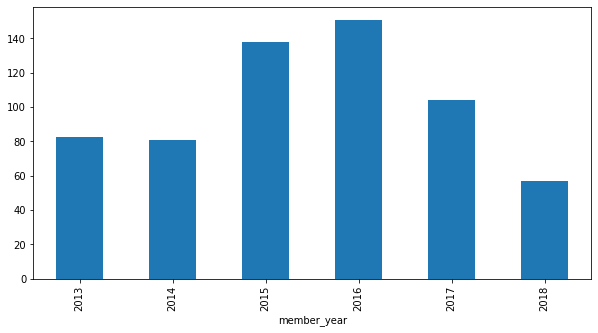

In [273]:
fig, ax = plt.subplots(figsize=(10,5))
agg = final_df.groupby(by=['member_year'])['total spending'].mean().plot(kind='bar')

<b style="color:red;"> Observation: </b>
- tenure doesn't seem to play any role in increasing amount of transactions. 

- Number of bogo and discount offers availed by each gender. 

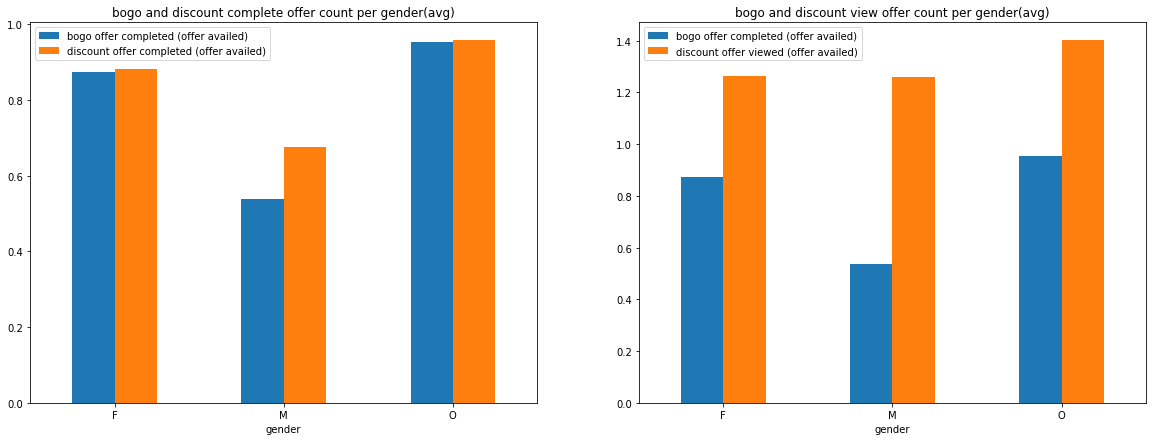

In [67]:
fig, ax = plt.subplots(ncols=2, figsize=(20,7))
final_df.groupby(by=['gender'])['bogo offer completed (offer availed)','discount offer completed (offer availed)'].mean().plot(kind='bar',rot=0,title="bogo and discount complete offer count per gender(avg)",ax=ax[0])
final_df.groupby(by=['gender'])['bogo offer completed (offer availed)','discount offer viewed (offer availed)'].mean().plot(kind='bar',rot=0,title="bogo and discount view offer count per gender(avg)",ax=ax[1])

<b style="color:red;"> Observation: </b>
- Discount offer have high view rate in all genders but males have high tendency to go for discount then bogo whereas the completion rate of bogo and discount for the rest of the genders are roughly same. (bogo offer completed with gender can create a distinction). 

- Regular and Seasonal Customer

In [282]:
final_df = final_df.assign(cus_type=final_df['invalid'].apply(lambda x: 1 if x > 0 else 0))

- Number of transactions. 

In [276]:
final_df = add_no_transactions(final_df, trans_dt)

In [285]:
final_df.groupby(by=['cus_type'])['total_transactions'].describe()

,count,mean,std,min,25%,50%,75%,max
cus_type,,,,,,,,
0,10317.0,7.825821,4.929475,1.0,4.0,7.0,10.0,36.0
1,6261.0,9.297876,5.006951,1.0,5.0,8.0,12.0,36.0


- Offer complete to no. of transaction ratio. 

In [340]:
final_df = final_df.assign(offer_trans_ratio= final_df['custom offer completed']/final_df['total_transactions'])

### 2.3 One hot encoding for categorical features 

In [341]:
X = pd.get_dummies(final_df)
X 

,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,total spending,...,cus_type,offer_trans_ratio,gender_F,gender_M,gender_O,"age_bucket_(17.9, 38.0]","age_bucket_(38.0, 58.0]","age_bucket_(58.0, 78.0]","age_bucket_(78.0, 98.0]","age_bucket_(98.0, 118.0]"
68be06ca386d4c31939f3a4f0e3dd783,118,2017-02-12,65404.991568,0.0,5.0,5.0,9.0,2.0,2.266667,20.40,...,0,0.222222,0,1,0,0,0,0,0,1
0610b486422d4921ae7d2bf64640c50b,55,2017-07-15,112000.000000,1.0,2.0,0.0,3.0,1.0,25.670000,77.01,...,1,0.000000,1,0,0,0,1,0,0,0
38fe809add3b4fcf9315a9694bb96ff5,118,2018-07-12,65404.991568,0.0,2.0,2.0,6.0,0.0,2.383333,14.30,...,0,0.000000,0,1,0,0,0,0,0,1
78afa995795e4d85b5d9ceeca43f5fef,75,2017-05-09,100000.000000,1.0,4.0,4.0,7.0,3.0,22.752857,159.27,...,1,0.285714,1,0,0,0,0,1,0,0
a03223e636434f42ac4c3df47e8bac43,118,2017-08-04,65404.991568,0.0,5.0,3.0,3.0,0.0,1.550000,4.65,...,0,0.000000,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,45,2018-06-04,54000.000000,0.0,3.0,3.0,7.0,0.0,2.861429,20.03,...,0,0.000000,1,0,0,0,1,0,0,0
2cb4f97358b841b9a9773a7aa05a9d77,61,2018-07-13,72000.000000,1.0,3.0,1.0,7.0,1.0,3.710000,25.97,...,1,0.000000,0,1,0,0,0,1,0,0
01d26f638c274aa0b965d24cefe3183f,49,2017-01-26,73000.000000,0.0,3.0,1.0,8.0,0.0,4.967500,39.74,...,0,0.000000,0,1,0,0,1,0,0,0
9dc1421481194dcd9400aec7c9ae6366,83,2016-03-07,50000.000000,2.0,3.0,3.0,14.0,3.0,13.547857,189.67,...,1,0.071429,1,0,0,0,0,0,1,0


## 3. Clustering 

### 3.1 Clustering without any preprocessing (scaling and PCA)

In [308]:
from sklearn.decomposition import PCA

In [300]:
def pca_fit_transform(df, var = None):
    pca = PCA(var)
    transform_arr = pca.fit_transform(df)
    return pca, transform_arr


In [166]:
pca_main = PCA()
pca_main, pca_transform_main = pca_fit_transform(X, var=0.95)

In [167]:
pca_transform_main

array([[   -76.39778486,  -3176.98694247],
       [ 46493.13917716,  -4797.88431392],
       [  -328.34469087, -13673.9597373 ],
       ...,
       [  7518.4937946 ,  -3273.23348844],
       [-15238.94739663,   7095.09959121],
       [ 16501.79262363,  -4084.86582944]])

In [301]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
#     for i in range(num_components):
#         ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')



Number of Main PCA components that explained at least 95% variance : 2


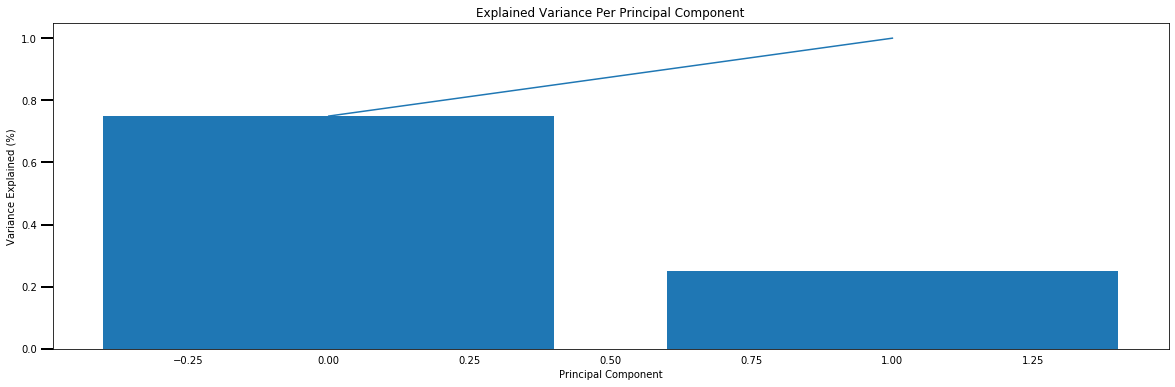

In [169]:
scree_plot(pca_main)

#PCA
# number of PCA components that explained at least 95% variance ==> 34 components
cumvals = np.cumsum(pca_main.explained_variance_ratio_)
print("Number of Main PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

In [302]:
def plot_weight(df, pca, ith) :
    '''
    plot weight for the i-th principal component to corresponding feature names
    Input : 
        df = original dataframe
        pca = pca.fit(data)
        ith = int value, from 1 to len(pca.n_components)
    Return : axes of barplot 
    '''
    sort_pca = sorted([(weight, label) for weight,label in zip(pca.components_[ith-1], df.columns) ])
    weights, features = zip(*sort_pca)
    weights, features = list(weights), list(features)
    fig, ax = plt.subplots(figsize=(10,20))
    ax = sns.barplot(weights, features)
    return ax


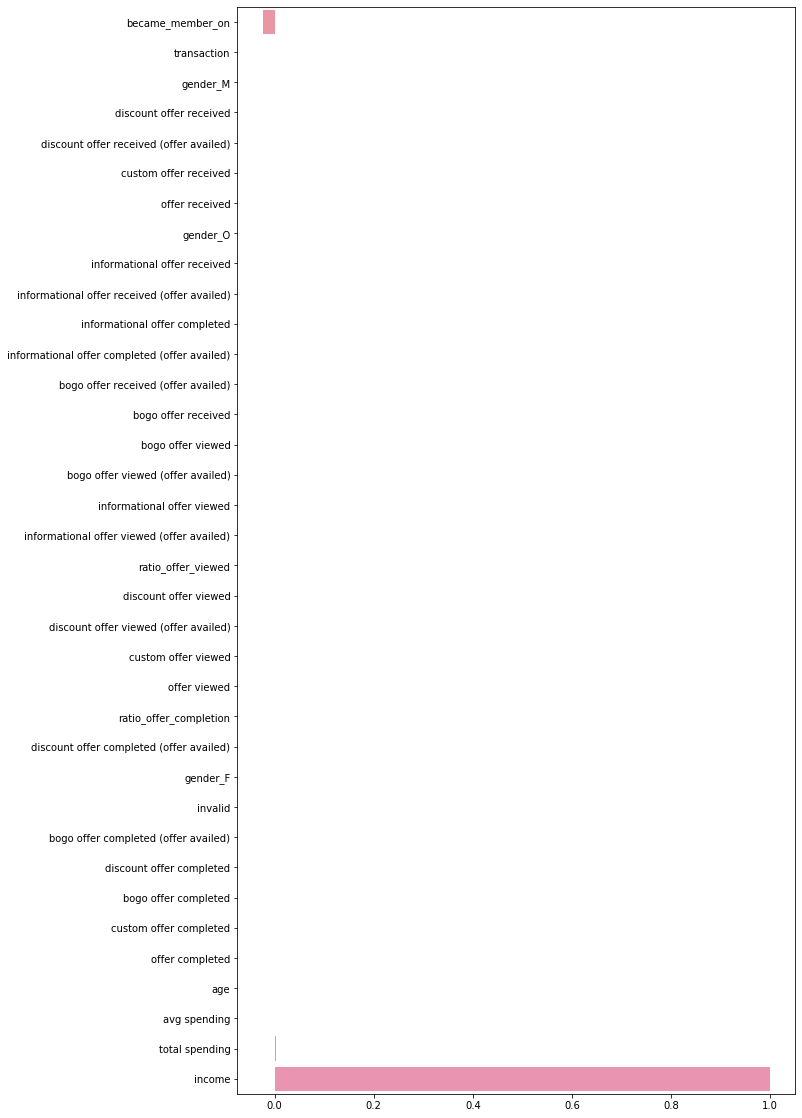

In [171]:
# 1st PCA comp
plot_weight(X,pca_main, 1 )

In [303]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import  silhouette_score
from tqdm import tqdm

def finding_num_cluster(X, min_clusters =2, max_clusters =30):
    silh = []
    inertia = []
    clusters = range(min_clusters,max_clusters)
    for n in tqdm(clusters):

        model = KMeans(n_clusters = n, random_state=42)
        preds = model.fit_predict(X)

        silhouette_avg = silhouette_score(X, preds)

        silh.append(silhouette_avg)
        inertia.append(model.inertia_)

    fig, (ax1,ax2) = plt.subplots(2,1, sharex=False, figsize=(8,7))
    ax1.plot(clusters, silh,marker="o")
    ax1.set_ylabel("Silhoutte Score")
    ax1.set_xlabel('number of clusters')
    ax2.plot(clusters, inertia, marker="o")
    ax2.set_ylabel("Inertia (SSE)")
    ax2.set_xlabel("number of clusters")
    plt.show()



100%|██████████| 28/28 [03:27<00:00,  7.42s/it]


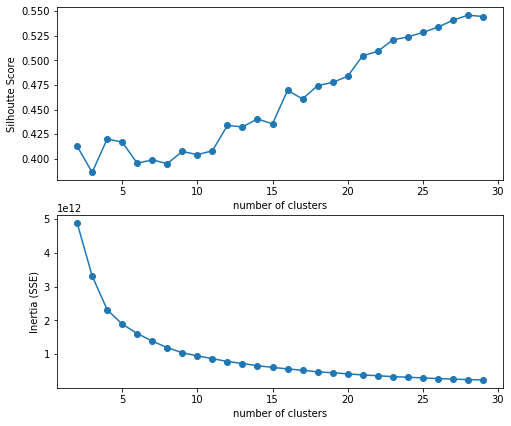

In [22]:
finding_num_cluster(pca_transform_main)

### 3.2 Clustering with preprocessing (Scaling)

In [344]:
X = pd.get_dummies(final_df)

In [345]:
X.columns

Index(['age', 'became_member_on', 'income', 'invalid', 'offer received',
       'offer viewed', 'transaction', 'offer completed', 'avg spending',
       'total spending', 'custom offer received', 'custom offer viewed',
       'custom offer completed', 'ratio_offer_completion',
       'ratio_offer_viewed', 'bogo offer received', 'bogo offer viewed',
       'bogo offer completed', 'discount offer received',
       'discount offer viewed', 'discount offer completed',
       'informational offer received', 'informational offer viewed',
       'informational offer completed', 'bogo offer received (offer availed)',
       'bogo offer viewed (offer availed)',
       'bogo offer completed (offer availed)',
       'discount offer received (offer availed)',
       'discount offer viewed (offer availed)',
       'discount offer completed (offer availed)',
       'informational offer received (offer availed)',
       'informational offer viewed (offer availed)',
       'informational offer complet

In [383]:
X = final_df.copy()
X = pd.get_dummies(X)

In [384]:
X = X[['age','income','avg spending',
       'total spending','gender_F','gender_M', 'gender_O','invalid']]

In [385]:
X['offer_trans_ratio'] = X['offer_trans_ratio'].fillna(0)
X['total_transactions'] = X['total_transactions'].fillna(0)

KeyError: 'offer_trans_ratio'

In [386]:
from sklearn.preprocessing import StandardScaler

def perform_scaling(df):
    scaler = StandardScaler()
    std_arr = scaler.fit_transform(df)
    df_std = pd.DataFrame(std_arr, index=df.index, columns= df.columns)
    return df_std, scaler


In [387]:
profile_std_main, scaler_main = perform_scaling(X)

In [388]:
pca_main, pca_transform_main = pca_fit_transform(profile_std_main, var=0.95)

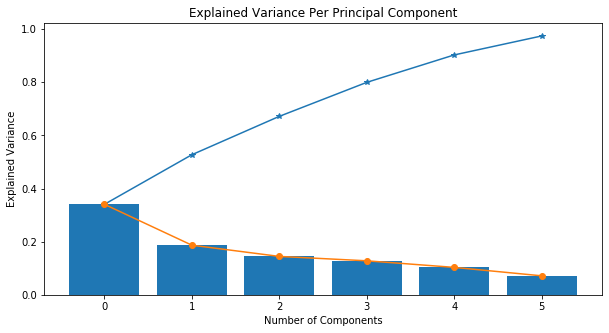

Number of Main PCA components that explained at least 95% variance : 6


In [389]:
scree_plot(pca_main)

#PCA
# number of PCA components that explained at least 95% variance ==> 34 components
cumvals = np.cumsum(pca_main.explained_variance_ratio_)
print("Number of Main PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

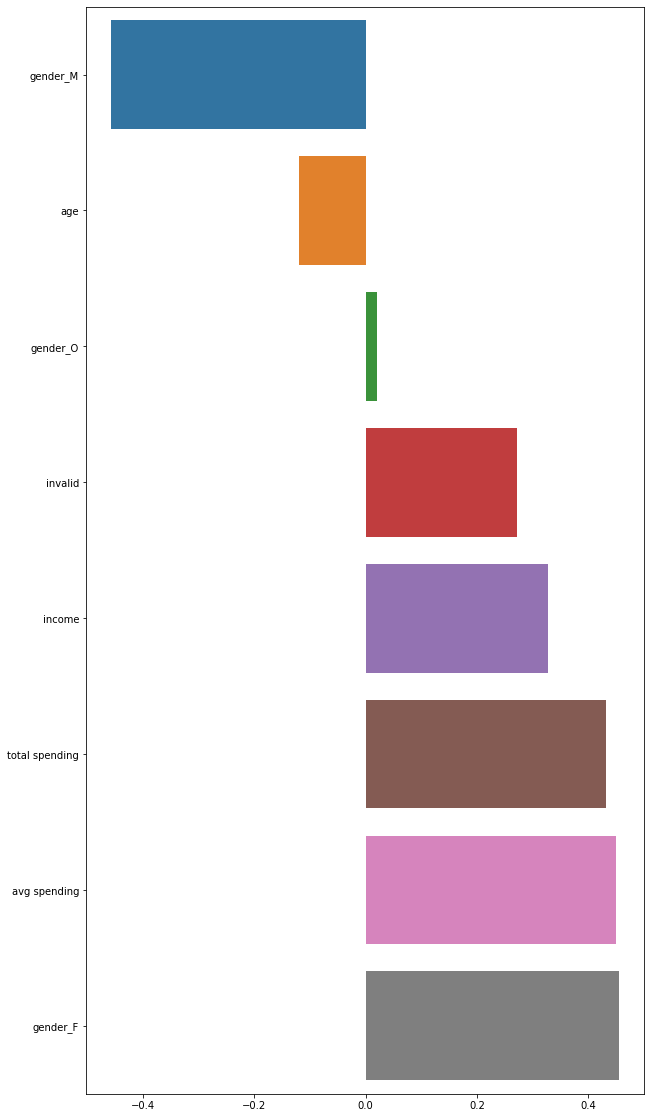

In [390]:
# 1st PCA comp
plot_weight(X,pca_main, 1 )

In [391]:
len(pca_main.components_)

6

100%|██████████| 14/14 [01:43<00:00,  7.37s/it]


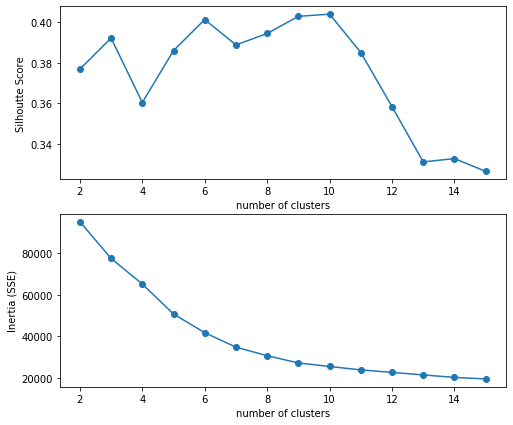

In [392]:
finding_num_cluster(pca_transform_main,max_clusters=16)

### 3.3 Clustering with my function 

In [181]:
## Scale and initialize PCA #

In [379]:
def scree_plot(pca):
    """
    draw a scree plot to determine the optimal components for pca 
    """
    # total number of components #
    num_components = len(pca.explained_variance_ratio_)
    # create array (size == number of components)
    components = np.arange(num_components)
    # variance of each component # 
    variance = np.array(pca.explained_variance_ratio_)
    # cumulative sum of variance #
    cum_variance = np.cumsum(variance)
    
    # time for plotting #
    plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    ax.bar(components, variance)
    ax.plot(components, cum_variance, marker="*")
    ax.plot(components, variance, marker="o")
    ax.set_title('Explained Variance Per Principal Component')
    ax.set_ylabel('Explained Variance')
    ax.set_xlabel('Number of Components')
    plt.show()
    

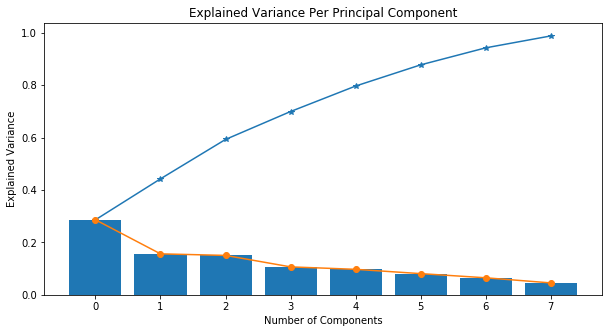

In [380]:
scree_plot(pca_main)

In [381]:
def evaluation_metric(features, min_cluster=2, max_cluster=20):
    """
    Determine the appropriate number of clusters based on different  
    standard metric such as inertia and silohutte
    """
    silhouette = []
    inertia = []
    clusters = range(min_cluster, max_cluster)
    for cluster in tqdm(clusters):
        K_means = KMeans(n_clusters = cluster)
        preds = K_means.fit_predict(features)
        silhouette.append(silhouette_score(features, preds))
        inertia.append(K_means.inertia_)
    metrics = [silhouette, inertia]
    titles = ['Silhouette score Per Cluster','Inertia (SSE) Per Cluster']
    y_labels = ['Silhouette score','Inertia (SSE)']
    # time for plotting #
    fig, axes = plt.subplots(nrows=2,figsize=(10,10))
    for ax,y,title,ylabel in zip(axes,metrics,titles,y_labels):
        ax.plot(clusters, y, marker='o')
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xticks([i for i in range(min_cluster,max_cluster)])
        ax.set_xlabel('Number of Clusters')
        
        
        

100%|██████████| 14/14 [01:46<00:00,  7.59s/it]


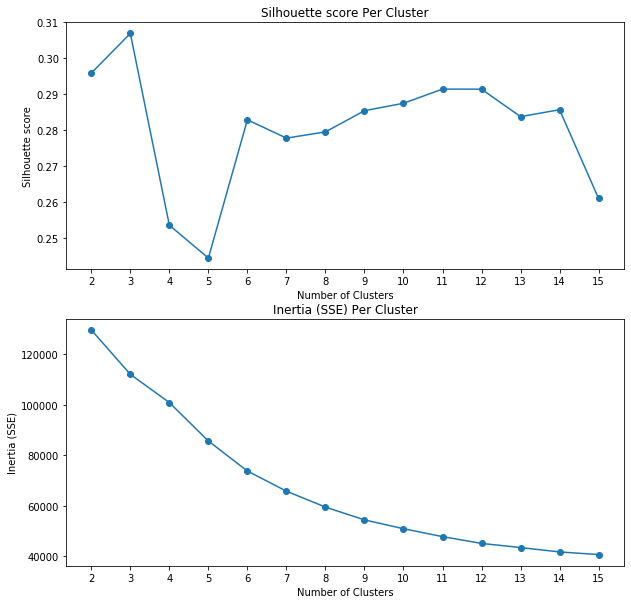

In [382]:
evaluation_metric(pca_transform_main, max_cluster=16)

In [393]:
### 3.4 Finally perform Kmean clustering (with 15 clusters)
k_means = KMeans(n_clusters=10)
preds_cluster = k_means.fit_predict(pca_transform_main)

In [394]:
final_df['Cluster'] = preds_cluster

## 4. Visualizing Clusters & Making Sense of it: 

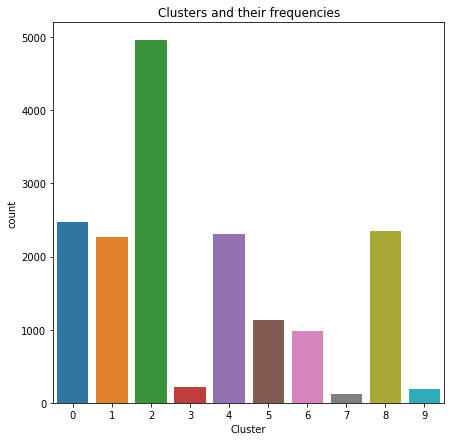

In [395]:
fig, ax = plt.subplots(figsize=(7,7))
sns.countplot(final_df['Cluster'])
ax.set_title('Clusters and their frequencies')
plt.show()

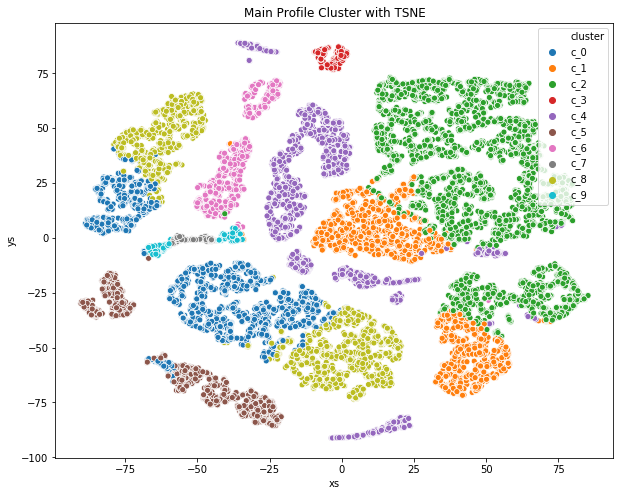

In [396]:
""" Visualise Cluster with TSNE"""
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42).fit_transform(pca_transform_main)
tsne_df = pd.DataFrame(tsne, columns=['xs', 'ys'])
tsne_df['cluster'] = ['c_' + str(i) for i in preds_cluster]

#plot tsne
f,ax = plt.subplots(figsize=(10,8))
sns.scatterplot('xs','ys', hue='cluster', data=tsne_df, ax=ax, hue_order=['c_' + str(i) for i in range(0,10)])
ax.set_title("Main Profile Cluster with TSNE")
#save fig
f.savefig('main_tsne.png', dpi = 300)

In [397]:
""" Cluster Centroid """

def inverse_transform_centroid(df, kmeans, pca, scaler):
    """ 
    INPUT : 
        df : dataframe
        kmeans : sklearn object of fitted KMeeans
        pca : sklearn object of fitted PCA
        scaler : sklearn object of fitted Scaler
    RETUNR :
        centers : dataframe of center value each cluster
    """
    centers = kmeans.cluster_centers_
    centers_pca = pca.inverse_transform(centers)
    centers = scaler.inverse_transform(centers_pca)
    centers = pd.DataFrame(centers, columns= df.columns)
    return centers

In [398]:
pd.set_option('display.max_columns', 500)
profile_main = final_df.copy()
profile_main_centroid = inverse_transform_centroid(X, k_means, pca_main, scaler_main)
profile_main_centroid

,age,income,avg spending,total spending,gender_F,gender_M,gender_O,invalid
0,51.703003,52033.685547,9.159144,82.934460,1.000036,-2.003991e-05,-0.000016,0.340377
1,59.828363,81566.093616,21.670865,140.517217,-0.000071,1.000039e+00,0.000031,0.410963
2,47.111322,50131.212585,5.353426,51.409447,0.000050,9.999721e-01,-0.000022,0.216411
3,54.373906,63145.917066,14.450467,120.922928,0.000001,-6.585470e-07,0.999999,0.450158
4,116.232284,64839.096056,3.744442,16.128962,-0.000053,1.000030e+00,0.000024,0.080674
5,58.930901,78425.073118,19.747766,171.665026,1.000066,-3.653815e-05,-0.000029,2.424970
6,54.462141,69496.606991,17.049276,165.061338,0.000044,9.999758e-01,-0.000019,2.375440
7,62.077477,96274.402911,124.899301,1029.579748,0.533289,4.594607e-01,0.007250,0.850296
8,63.099645,87880.026779,23.571983,144.031142,0.999908,5.102484e-05,0.000041,0.417469
9,51.562030,57149.610774,63.387416,563.525364,0.494065,5.055879e-01,0.000347,0.912451


In [399]:
def compare_features(df, features, xlabel = 'cluster', ylabel = 'std value', figsize = (10,8)):
    """ This function is just to plot selected features"""
    n_cols = len(features)
    rows = n_cols//2 + (n_cols % 2 >0)
    
    f, axs = plt.subplots(rows,2, figsize=figsize)
    axs = axs.flatten()

    for i in range(n_cols):
        sns.barplot(df.index,features[i], data= df, ax= axs[i])
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel(ylabel)
        axs[i].set_title('Feature : ' + features[i])
        
    plt.tight_layout()

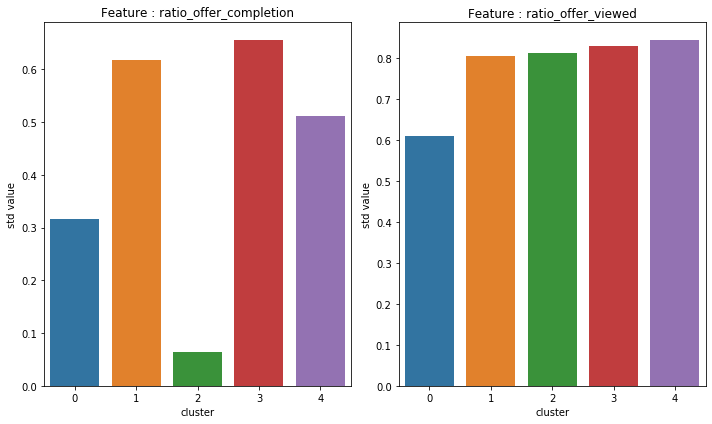

In [138]:
""" Visualize completed rate for each offer and cluster"""

features = [
    'ratio_offer_completion',
    'ratio_offer_viewed']

compare_features(profile_main_centroid, features, figsize=(10,6))

- Scatterplots for different clusters. 

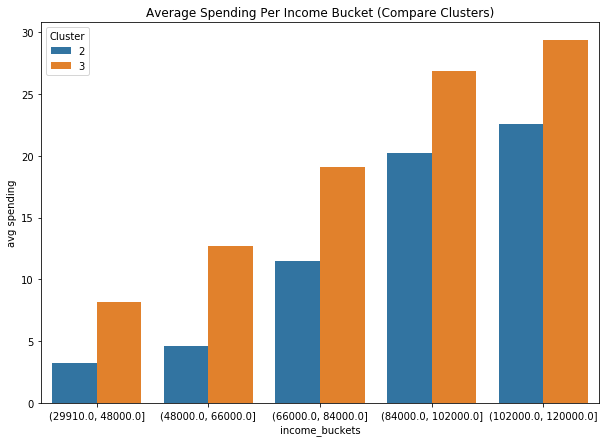

In [111]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x ='income_buckets',y ='avg spending', hue='Cluster',data=temp ,ci=False)
ax.set_title('Average Spending Per Income Bucket (Compare Clusters)')
plt.show()

<b style="color:red;"> Observation: </b>
Average Spending of Cluster 3 is high is all income buckets compared to cluster 2 

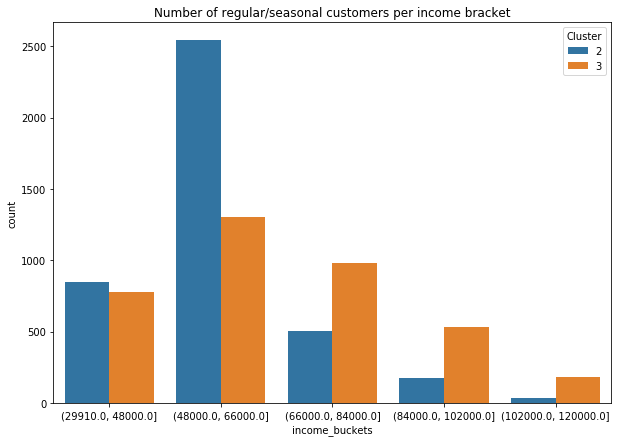

In [113]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x ='income_buckets', hue='Cluster',data=temp )
ax.set_title('Number of regular/seasonal customers per income bracket')
plt.show()

<b style="color:red;"> Observation: </b>
Cluster 2 contains regular customers and it is evident that two income buckets (from left) have high no of regular customer (often more than seasonal customers) and this number decline afterwards in rest of the income buckets. 

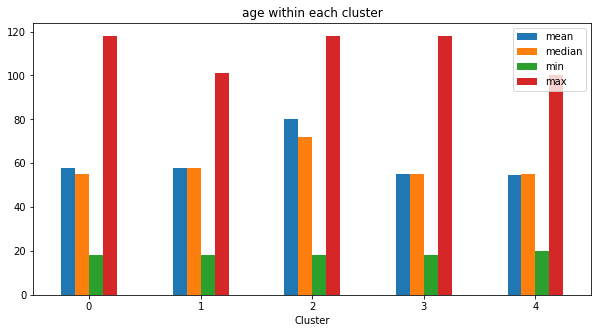

In [135]:
functions = ['mean','median','min','max']
agg = final_df.groupby(by=['Cluster'])['age'].agg(functions).plot(kind='bar',figsize=(10,5)
                                                                                ,rot=0,
                                                                                title='age within each cluster')


<b style="color:red;"> Observation: </b>
Not much difference between cluster w.r.t. age. 

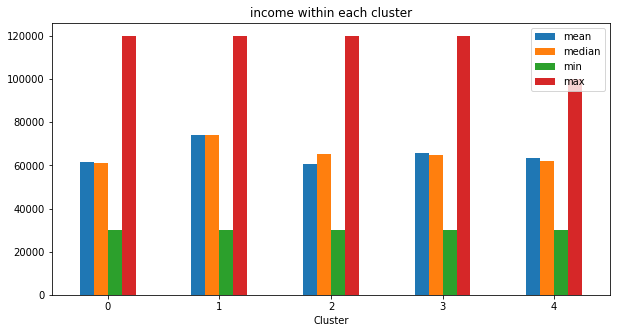

In [136]:
functions = ['mean','median','min','max']
agg = final_df.groupby(by=['Cluster'])['income'].agg(functions).plot(kind='bar',figsize=(10,5)
                                                                                ,rot=0,
                                                                                title='income within each cluster')


<b style="color:red;"> Observation: </b>
Not much difference between cluster w.r.t. income. 

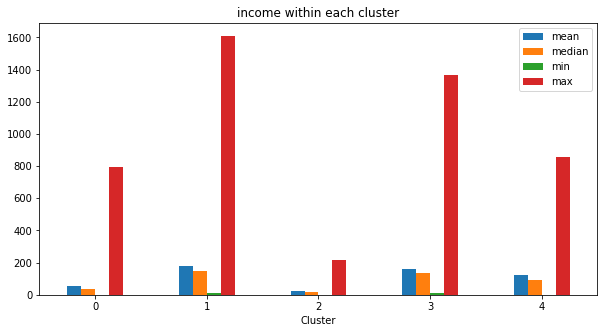

In [137]:
functions = ['mean','median','min','max']
agg = final_df.groupby(by=['Cluster'])['total spending'].agg(functions).plot(kind='bar',figsize=(10,5)
                                                                                ,rot=0,
                                                                                title='income within each cluster')


<b style="color:red;"> Observation: </b>
total spending of C0 and C2 is low compared with C1,C3 and C4. 

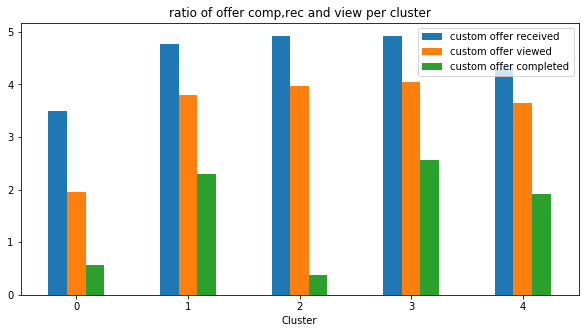

In [149]:
functions = ['mean']#,'median','min','max']
agg = final_df.groupby(by=['Cluster'])['custom offer received','custom offer viewed','custom offer completed'].mean().plot(kind='bar',figsize=(10,5),rot=0,title='ratio of offer comp,rec and view per cluster')
plt.show()

<b style="color:red;"> Observation: </b>
offer comp ratio in C0 and C2 is low compared with C1,C3 and C4. Perhaps if ppl in C0 viewed more offers they had completed more offer (as this C0 has bit high comp rate compared to C1)

In [151]:
final_df

,gender,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,total spending,custom offer received,custom offer viewed,custom offer completed,ratio_offer_completion,ratio_offer_viewed,Cluster
68be06ca386d4c31939f3a4f0e3dd783,M,118,20170212,65404.991568,0.0,5.0,5.0,9.0,2.0,2.266667,20.40,5,5,2,0.400000,1.000000,2
0610b486422d4921ae7d2bf64640c50b,F,55,20170715,112000.000000,1.0,2.0,0.0,3.0,1.0,25.670000,77.01,2,0,0,0.400000,0.000000,0
38fe809add3b4fcf9315a9694bb96ff5,M,118,20180712,65404.991568,0.0,2.0,2.0,6.0,0.0,2.383333,14.30,2,2,0,0.000000,1.000000,0
78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.000000,1.0,4.0,4.0,7.0,3.0,22.752857,159.27,4,4,2,0.500000,1.000000,1
a03223e636434f42ac4c3df47e8bac43,M,118,20170804,65404.991568,0.0,5.0,3.0,3.0,0.0,1.550000,4.65,5,3,0,0.000000,0.600000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45,20180604,54000.000000,0.0,3.0,3.0,7.0,0.0,2.861429,20.03,3,3,0,0.000000,1.000000,0
2cb4f97358b841b9a9773a7aa05a9d77,M,61,20180713,72000.000000,1.0,3.0,1.0,7.0,1.0,3.710000,25.97,3,1,0,0.000000,0.333333,0
01d26f638c274aa0b965d24cefe3183f,M,49,20170126,73000.000000,0.0,3.0,1.0,8.0,0.0,4.967500,39.74,3,1,0,0.000000,0.333333,0
9dc1421481194dcd9400aec7c9ae6366,F,83,20160307,50000.000000,2.0,3.0,3.0,14.0,3.0,13.547857,189.67,3,3,1,0.333333,1.000000,1
